In [772]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [773]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

There are 7 features with more than 80% missing values


<Axes: title={'center': 'Percentage of missing values in the training data'}, xlabel='Features', ylabel='Percentage'>

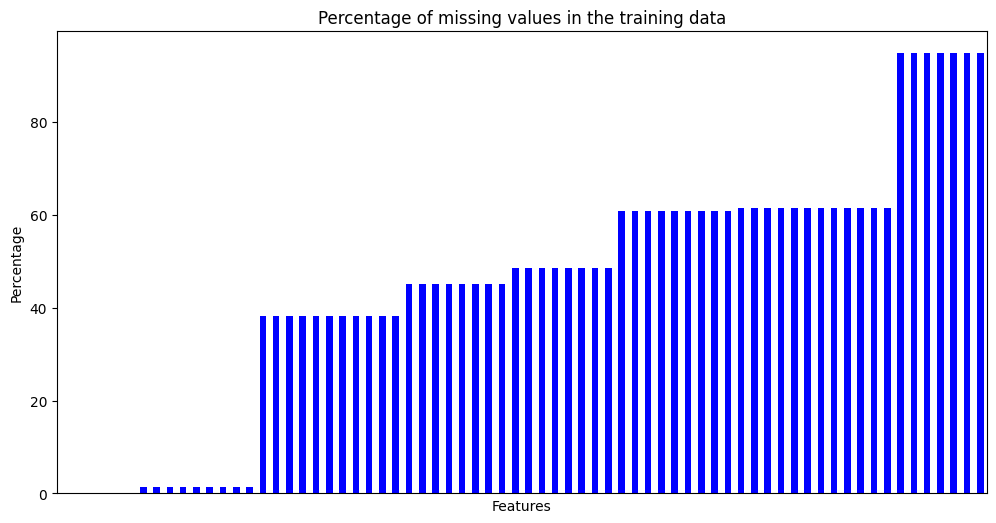

In [774]:
#plot the The percentage of available data for each feature
missing = (train.isnull().sum() / len(train)) * 100
missing = missing[missing > 0]
missing.sort_values(inplace=True)

#count number of missing features with 80%+
missing_features = missing[missing > 75].count()
print(f'There are {missing_features} features with more than 80% missing values')

#plot column names with 80%+ missing
# missing.plot.bar(figsize=(12, 6), color='blue', title='Percentage of missing values in the training data', ylabel='Percentage', xlabel='Features')

#plot the missing values with a good graph with a title without the x labels
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
missing.plot.bar(ax=ax, color='blue', title='Percentage of missing values in the training data', ylabel='Percentage', xlabel='Features')


In [775]:
#drop the columns less than 75% full
train = train.dropna(thresh=0.25*len(train), axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [777]:
#drop all rows with 50% of missing values
percentage_available = 0.5
train = train.dropna(thresh=(percentage_available)*len(train.columns), axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4845 entries, 1 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        4845 non-null   object 
 1   site_id                                                   4845 non-null   object 
 2   site_latitude                                             4845 non-null   float64
 3   site_longitude                                            4845 non-null   float64
 4   city                                                      4845 non-null   object 
 5   country                                                   4845 non-null   object 
 6   date                                                      4845 non-null   object 
 7   hour                                                      4845 non-null   int64  
 8   sulphurdioxide_so2_colu

In [778]:
# combine city and country into one column
train['Location'] = train['country'] + ', ' + train['city']
train.drop(['country', 'city', 'id'], axis=1, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4845 entries, 1 to 8070
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   site_id                                                   4845 non-null   object 
 1   site_latitude                                             4845 non-null   float64
 2   site_longitude                                            4845 non-null   float64
 3   date                                                      4845 non-null   object 
 4   hour                                                      4845 non-null   int64  
 5   sulphurdioxide_so2_column_number_density                  3159 non-null   float64
 6   sulphurdioxide_so2_column_number_density_amf              3159 non-null   float64
 7   sulphurdioxide_so2_slant_column_number_density            3159 non-null   float64
 8   sulphurdioxide_cloud_fr

In [779]:
# one hot encode the Location and site_id columns

train = pd.get_dummies(train, columns=['site_id'])
train = pd.get_dummies(train, columns=['Location'])
train.info()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
count,4845.000000,4845.000000,4845.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,4845.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,4845.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,4845.000000
mean,0.735972,29.785505,10.858617,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,6.045408,0.034939,2178.743958,1996.343022,829573.937433,-8.475524,39.095140,-91.105115,28.615874,0.000074,0.000040,0.000033,0.000130,8837.666305,-0.362639,0.082063,829580.767718,-12.841087,37.314307,-93.822009,28.862317,0.000174,1.051809,0.000109,0.189567,28.037418,-91.979467,40.020299,-2.631763,-0.443091,829573.518806,-5.059012,40.545992,-91.077469,28.302953,0.117669,2.622016,0.313074,228.892523,0.279964,-5.059010,40.545987,-91.077447,28.302953,0.363419,56896.495280,5252.648303,63959.509069,4279.854084,7.400471,0.248089,-12.369953,45.322505,-87.740882,28.625709,24.612191
std,2.299625,10.114172,0.831382,0.000354,0.142544,0.000220,0.094129,85.450554,18.964322,43.240479,6.844252,0.000092,3.510983,0.011331,913.155505,1359.581431,341.288913,83.037729,18.143457,41.818498,6.676161,0.000034,0.000034,0.000002,0.000041,992.109190,0.771899,0.

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

non_categorial = train.select_dtypes(exclude='object')

train_imputed = pd.DataFrame(imputer.fit_transform(train), columns=non_categorial.columns, index=train.index)

train_imputed.info()

In [ ]:
train.describe(include=['O'])



## Feature Engineering

In [ ]:
train.describe()



In [ ]:
# summarise categorical variables
train.describe(include=['O'])

In [ ]:
# show pm2_5 distributions based on the site_id
plt.figure(figsize=(12, 6))
sns.boxplot(x='site_id', y='pm2_5', data=train)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# summarise categorical variables
train.describe(include=['O'])

# summarise the distributions of pm2_5 based on the Location variable
train.groupby('Location')['pm2_5'].describe()

In [ ]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train)

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

In [ ]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train, hue='Location')

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

In [ ]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='month', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

In [ ]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='hour', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()



In [ ]:
# list non-categorical columns
non_categorical = train.select_dtypes(include=[np.number]).columns
# remove hour, month, latitude and longitude from this list
non_categorical = non_categorical.drop(['hour', 'month', 'site_latitude', 'site_longitude', 'pm2_5'])
non_categorical

# Now we are training the regression model

In [ ]:
# One-hot encode the 'site_id' column
train = pd.get_dummies(train, columns=['site_id'], drop_first=True)


In [ ]:
# one hot encode the Location column
train = pd.get_dummies(train, columns=['site_id'], drop_first=True)
train = pd.get_dummies(train, columns=['Location'])

In [ ]:
train.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Drop the hour column
train = train.drop(columns=['hour', 'id'])

# One hot encode the
# Feature engineering
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_month'] = train['date'].dt.day
train['year'] = train['date'].dt.year

# Drop the original 'date' column
train = train.drop(columns=['date'])
# Normalization
scaler = StandardScaler()
# scale the columns in the non-categorical columns list
train[non_categorical] = scaler.fit_transform(train[non_categorical])

train.head()


In [ ]:
train.describe()

#apply transformation to pm2_5 level to reduce skewness

#plot day of the week vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_week', y='pm2_5', data=train)
plt.title('Day of the week vs pm2_5')
plt.show()

#plot day of the month vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_month', y='pm2_5', data=train)
plt.title('Day of the month vs pm2_5')
plt.show()

#plot year vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='pm2_5', data=train)
plt.title('Year vs pm2_5')
plt.show()


In [ ]:
# Split the data into training and testing sets
X = train.drop(columns=['pm2_5'])

y = train['pm2_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# One hot encode the 'site_id' column

In [ ]:
# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))



print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define the neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with single node for regression

early_stop = EarlyStopping(monitor='val_loss', patience=100) 

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')

In [ ]:
#random forest tree
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Assess the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



In [ ]:
X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

In [ ]:
model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

In [ ]:

# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

In [ ]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


In [ ]:
# print a summary of each variable
train.describe()

In [ ]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()